## 1. Import Libraries

In [2]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, HTML

## 2. Parameter

In [9]:
# declare path
train_dir = '../archive/train'
test_dir = '../archive/test'

# classes
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

## 3. Prepare data

In [32]:
# Data augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [33]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  shuffle =False,
                                                  batch_size = 64)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 4. Explore data

archive/train/angry/Training_10120469.jpg
archive/train/disgust/Training_10598340.jpg
archive/train/fear/Training_10031494.jpg
archive/train/happy/Training_10046809.jpg
archive/train/neutral/Training_10031781.jpg
archive/train/sad/Training_10031481.jpg
archive/train/surprise/Training_1002457.jpg


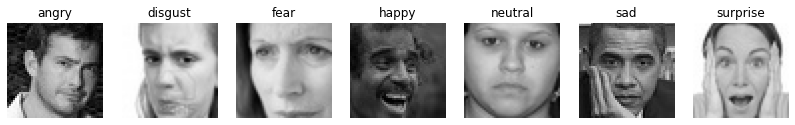

In [7]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    print(train_dir + "/" + expression + '/' + os.listdir(train_dir +"/"+ expression)[1])
    img = tf.keras.preprocessing.image.load_img((train_dir + "/" + expression + '/' + os.listdir(train_dir +"/"+ expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

In [3]:
# VGG16
base_model = tf.keras.applications.VGG16(input_shape= (48, 48, 3),include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [4]:
# Here to build VGG-16 model

model=tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 14,718,279
Non-trainable params: 0
_________________________________________________________________


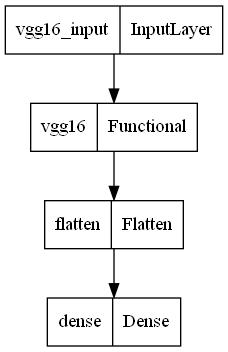

In [6]:
# plot the model
tf.keras.utils.plot_model(model, to_file='vgg16_basicmodel.jpg')

In [36]:
# Compile model

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [14]:
# run the model

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=70)
history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = 100,
                  verbose =1,
                  callbacks=[es])


Epoch 1/100
449/449 [==============================] - 27s 53ms/step - loss: 1.4573 - accuracy: 0.4414 - precision: 0.6993 - recall: 0.1989 - auc: 0.8087 - f1_score: 0.2977 - val_loss: 1.2930 - val_accuracy: 0.4960 - val_precision: 0.6677 - val_recall: 0.3525 - val_auc: 0.8570 - val_f1_score: 0.4610
Epoch 2/100
449/449 [==============================] - 22s 49ms/step - loss: 1.2413 - accuracy: 0.5298 - precision: 0.7262 - recall: 0.3238 - auc: 0.8675 - f1_score: 0.4447 - val_loss: 1.1688 - val_accuracy: 0.5561 - val_precision: 0.7239 - val_recall: 0.3927 - val_auc: 0.8839 - val_f1_score: 0.5042
Epoch 3/100
449/449 [==============================] - 22s 49ms/step - loss: 1.1509 - accuracy: 0.5635 - precision: 0.7391 - recall: 0.3774 - auc: 0.8873 - f1_score: 0.4976 - val_loss: 1.1054 - val_accuracy: 0.5847 - val_precision: 0.7759 - val_recall: 0.4057 - val_auc: 0.8958 - val_f1_score: 0.5281
Epoch 4/100
449/449 [==============================] - 23s 50ms/step - loss: 1.0831 - accuracy: 0

In [15]:
# save model weights
model.save_weights('../Project/weights/weight4')

In [5]:
# load model weights
model.load_weights('../Project/weights/weight4')

## 6. Evaluate Model

### 6.1 Check some Score 

In [16]:
# evaluation of train & test set

train_evaluation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 2s 16ms/step - loss: 2.0681 - accuracy: 0.6516 - precision: 0.6629 - recall: 0.6414 - auc: 0.8776 - f1_score: 0.6493


In [17]:
metric_list = ["Loss","accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evaluation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))




Model Scores



,Metric Name,Train,Validate
0,Loss,0.100,2.068
1,accuracy,0.963,0.652
2,Precision,0.967,0.663
3,Recall,0.961,0.641
4,Auc,0.999,0.878
5,F1_Score,0.964,0.649


### 6.2 Visualize results

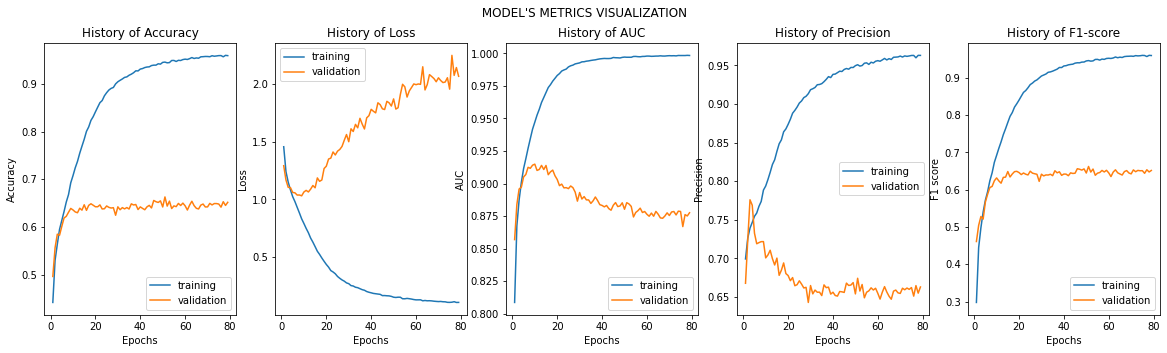

In [18]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

# plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

### 6.3 Confusion Matrix

In [38]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 [==============================] - 9s 76ms/step


Confusion matrix, without normalization

[[ 555    6  114   51   85  113   34]
 [  19   69    6    4    5    6    2]
 [ 101    2  561   36   96  135   93]
 [  62    0   49 1457  119   42   45]
 [  76    0  100   94  733  187   43]
 [ 145    2  175   71  213  617   24]
 [  21    1   57   31   22   14  685]]





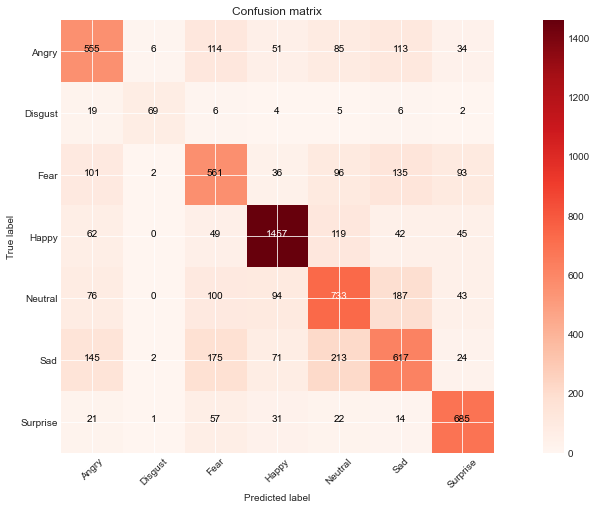

In [40]:
plt.rcParams['figure.figsize'] = (14,7)

# plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

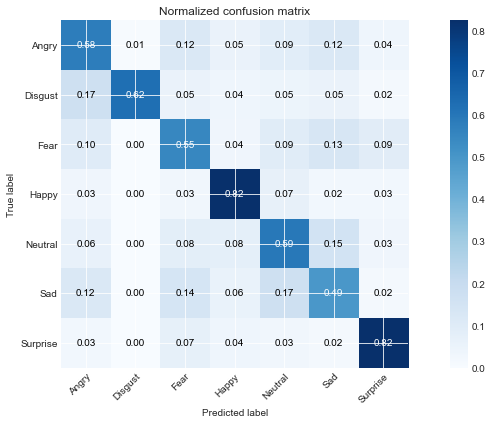

In [41]:
# plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


## 7. Test example

(48, 48, 1)


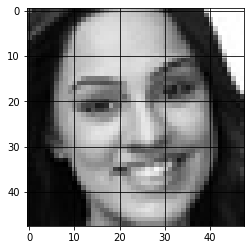

In [6]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='../archive/test/happy/PrivateTest_10613684.jpg'
test_image=tf.keras.preprocessing.image.load_img(img_path,target_size= (48, 48),color_mode='grayscale')
test_image=tf.keras.preprocessing.image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [7]:
img=tf.keras.preprocessing.image.load_img(img_path,target_size=(48,48))
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [10]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

1/1 [==============================] - 0s 16ms/step
[0. 0. 0. 1. 0. 0. 0.]
The person facial emotion is: Happy
